In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
REGIONS    = {
    'Eastern Arabian Sea':{'latmin':8.,'latmax':18.,'lonmin':66.,'lonmax':72.5}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':77.,'lonmax':83.},
    'Northern Bay of Bengal':{'latmin':18.,'latmax':21.5,'lonmin':87.5,'lonmax':90.},
    'Central Bay of Bengal':{'latmin':8.5,'latmax':13.5,'lonmin':86.,'lonmax':90.}} 
SAVEPATH = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs/'
LATMIN     = 5.
LATMAX     = 25.
LONMIN     = 60.
LONMAX     = 90.
PRTHRESH   = 0.25

In [3]:
def convert_common_units(data):
    coeff = 9.8/(3*340)
    dims  = ['time','lat','lon']
    newdata = xr.Dataset(
    data_vars=dict(
        pr=(dims,data.pr.data),
        bl=(dims,data.bl.data),
        cape=(dims,(coeff*data.wb.data*data.cape.data)),
        subsat=(dims,(coeff*data.wl.data*data.subsat.data))),
    coords=dict(time=data.time.data,lat=data.lat.data,lon=data.lon.data))
    return newdata

def apply_precipitating_mask(data,prthresh=PRTHRESH):
    return data.where(data.pr>prthresh)

def open_data(precipitating=False,convertunits=False,prthresh=PRTHRESH):
    file = '/ocean/projects/atm200007p/sferrett/Repos/archived/data/processed/OBS-HR_bl-pr_EXTENDED.nc'
    data = xr.open_dataset(file)
    if precipitating==True:
        data = apply_precipitating_mask(data)
    if convertunits==True:
        data = convert_common_units(data)
    return data

In [4]:
data = open_data(precipitating=False,convertunits=False)

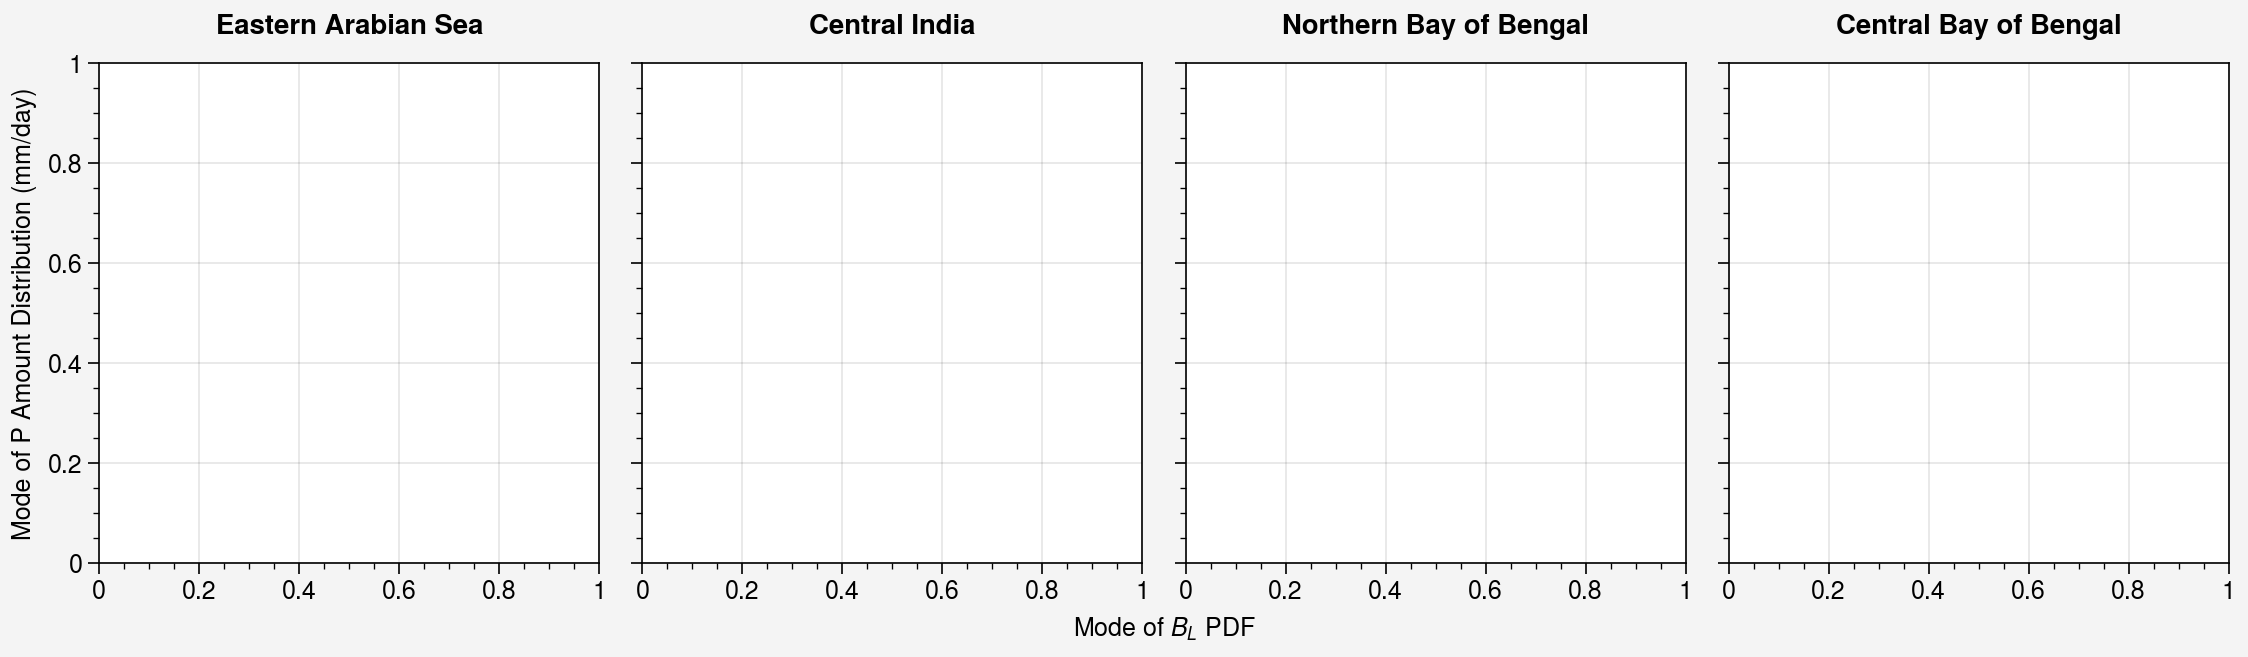

In [10]:
fig,axs = pplt.subplots(nrows=1,ncols=4,share=True)
axs.format(collabels=REGIONS.keys(),xlabel='Mode of $\mathit{B_L}$ PDF',ylabel='Mode of P Amount Distribution (mm/day)')

In [ ]:
def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_bin_centers(data,bintype='regular',binmin=None,binmax=None,binwidth=None,prthresh=PRTHRESH):
    if bintype=='regular':
        bincenters = np.arange(binmin,binmax+binwidth,binwidth)
        return bincenters
    elif bintype=='log':
        bincenters = [prthresh/np.sqrt(1+binwidth)]
        datamax = data.max().values
        while bincenters[-1]<datamax:
            nextcenter = bincenters[-1]*(1+binwidth)
            if nextcenter>datamax:
                break
            bincenters.append(nextcenter)
        return bincenters
    
    
    import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode

# Load your datasets
# Assuming 'pr' and 'bl' are your Xarray DataArrays
# pr = xr.open_dataset('precipitation_data.nc')['pr']
# bl = xr.open_dataset('buoyancy_data.nc')['bl']

# Calculate the mode for buoyancy and precipitation
def calculate_mode(data):
    # Flatten the data to 1D array and remove NaNs
    data_flat = data.values.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    
    # Calculate the mode
    mode_value, _ = mode(data_flat)
    return mode_value[0]

# Get the mode for each dataset
mode_pr = calculate_mode(pr)
mode_bl = calculate_mode(bl)

# Plot the modes
plt.figure(figsize=(8, 6))
plt.scatter(mode_bl, mode_pr, color='b', label='Mode')
plt.xlabel('Mode of Buoyancy Frequency Distribution')
plt.ylabel('Mode of Precipitation Frequency Distribution')
plt.title('Mode of Buoyancy vs. Precipitation')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
data = open_data()
for region in REGIONS:
    subset  = get_region(data,region)
    prbins  = get_bin_centers(subset.pr,bintype='log',binwidth=0.5)
    blbins  = get_bin_centers(subset.bl,bintype='regular',binmin=-0.1,binmax=0.05,binwidth=0.005)
    
    weights = get_area_weights(subset)
    fig,axs = setup_fig(region)
    for month,label,color in CASES:
        ds = get_month(subset,month)
        pramt = get_area_weighted_mean(calc_amt_dist(ds.pr,prbins),weights)
        blamt = get_area_weighted_mean(calc_amt_dist(ds.bl,blbins),weights)
        capeamt = get_area_weighted_mean(calc_amt_dist(ds.cape,capebins),weights)
        subsatamt = get_area_weighted_mean(calc_amt_dist(ds.subsat,subsatbins),weights)
        axs[0].plot(prbins,pramt,color=color,alpha=0.7)
        axs[1].plot(blbins,blamt,color=color,alpha=0.7)
        axs[2].plot(capebins,capeamt,color=color,alpha=0.7)
        axs[3].plot(subsatbins,subsatamt,color=color,alpha=0.7)
        axs[1].scatter([],[],label=label,color=color)
    axs[1].legend(loc='upper left',ncols=1)